# A/B тестирование

## Часть 1: Импорт библиотек и установка начальных параметров

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Определяем количество пользователей
num_users = 1000
np.random.seed(0)  # чтобы получить одинаковые результаты

## Часть 2: Генерация данных для контрольной и тестовой групп

In [2]:
# Генерируем данные для пользователей и объединяем датафреймы
control_group = pd.DataFrame({
    'user_id': np.arange(num_users),
    'group': 'A',
    'conversion': np.random.choice([0, 1], size=num_users, p=[0.5, 0.5])
})
np.random.seed(1)  # чтобы получить одинаковые результаты
test_group = pd.DataFrame({
    'user_id': np.arange(num_users, 2 * num_users),
    'group': 'B',
    'conversion': np.random.choice([0, 1], size=num_users, p=[0.45, 0.55])
})
ab_test_data = pd.concat([control_group, test_group], ignore_index=True)


In [3]:
ab_test_data

,user_id,group,conversion
0,0,A,1
1,1,A,1
2,2,A,1
3,3,A,1
4,4,A,0
...,...,...,...
1995,1995,B,1
1996,1996,B,0
1997,1997,B,1
1998,1998,B,0


## Часть 3: Выполнение A/B-тестирования и расчет статистической значимости

In [4]:
# Определяем функцию для расчета средних значений bootstrap
def bootstrap_means(data, n_bootstrap_samples=10000):
    bootstrap_sample_means = []
    for _ in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_sample_means.append(bootstrap_sample.mean())
    return bootstrap_sample_means

# Рассчитываем средние значения bootstrap для каждой группы
bootstrap_means_A = bootstrap_means(ab_test_data[ab_test_data['group'] == 'A']['conversion'])
bootstrap_means_B = bootstrap_means(ab_test_data[ab_test_data['group'] == 'B']['conversion'])

# Выполняем тест Хи-квадрат
contingency_table = pd.crosstab(ab_test_data['group'], ab_test_data['conversion'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)


## Часть 4: Подготовка данных для анализа и визуализации

In [5]:
# Добавляем искусственные метки времени
ab_test_data['timestamp'] = pd.date_range(start='1/1/2023', periods=len(ab_test_data), freq='H')

# Генерируем искусственные признаки "день недели" и "час дня"
ab_test_data['day_of_week'] = ab_test_data['timestamp'].dt.dayofweek
ab_test_data['hour_of_day'] = ab_test_data['timestamp'].dt.hour

# Рассчитываем средний коэффициент конверсии по дням недели и часам дня
conversion_by_dayofweek = ab_test_data.groupby(['day_of_week', 'group'])['conversion'].mean().unstack()
conversion_by_hourofday = ab_test_data.groupby(['hour_of_day', 'group'])['conversion'].mean().unstack()


C:\Users\User\AppData\Local\Temp\ipykernel_10604\3813093692.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ab_test_data['timestamp'] = pd.date_range(start='1/1/2023', periods=len(ab_test_data), freq='H')


## Часть 5: Визуализация результатов A/B-тестирования

C:\Users\User\AppData\Local\Temp\ipykernel_10604\52655431.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette="mako", ax=ax[0])


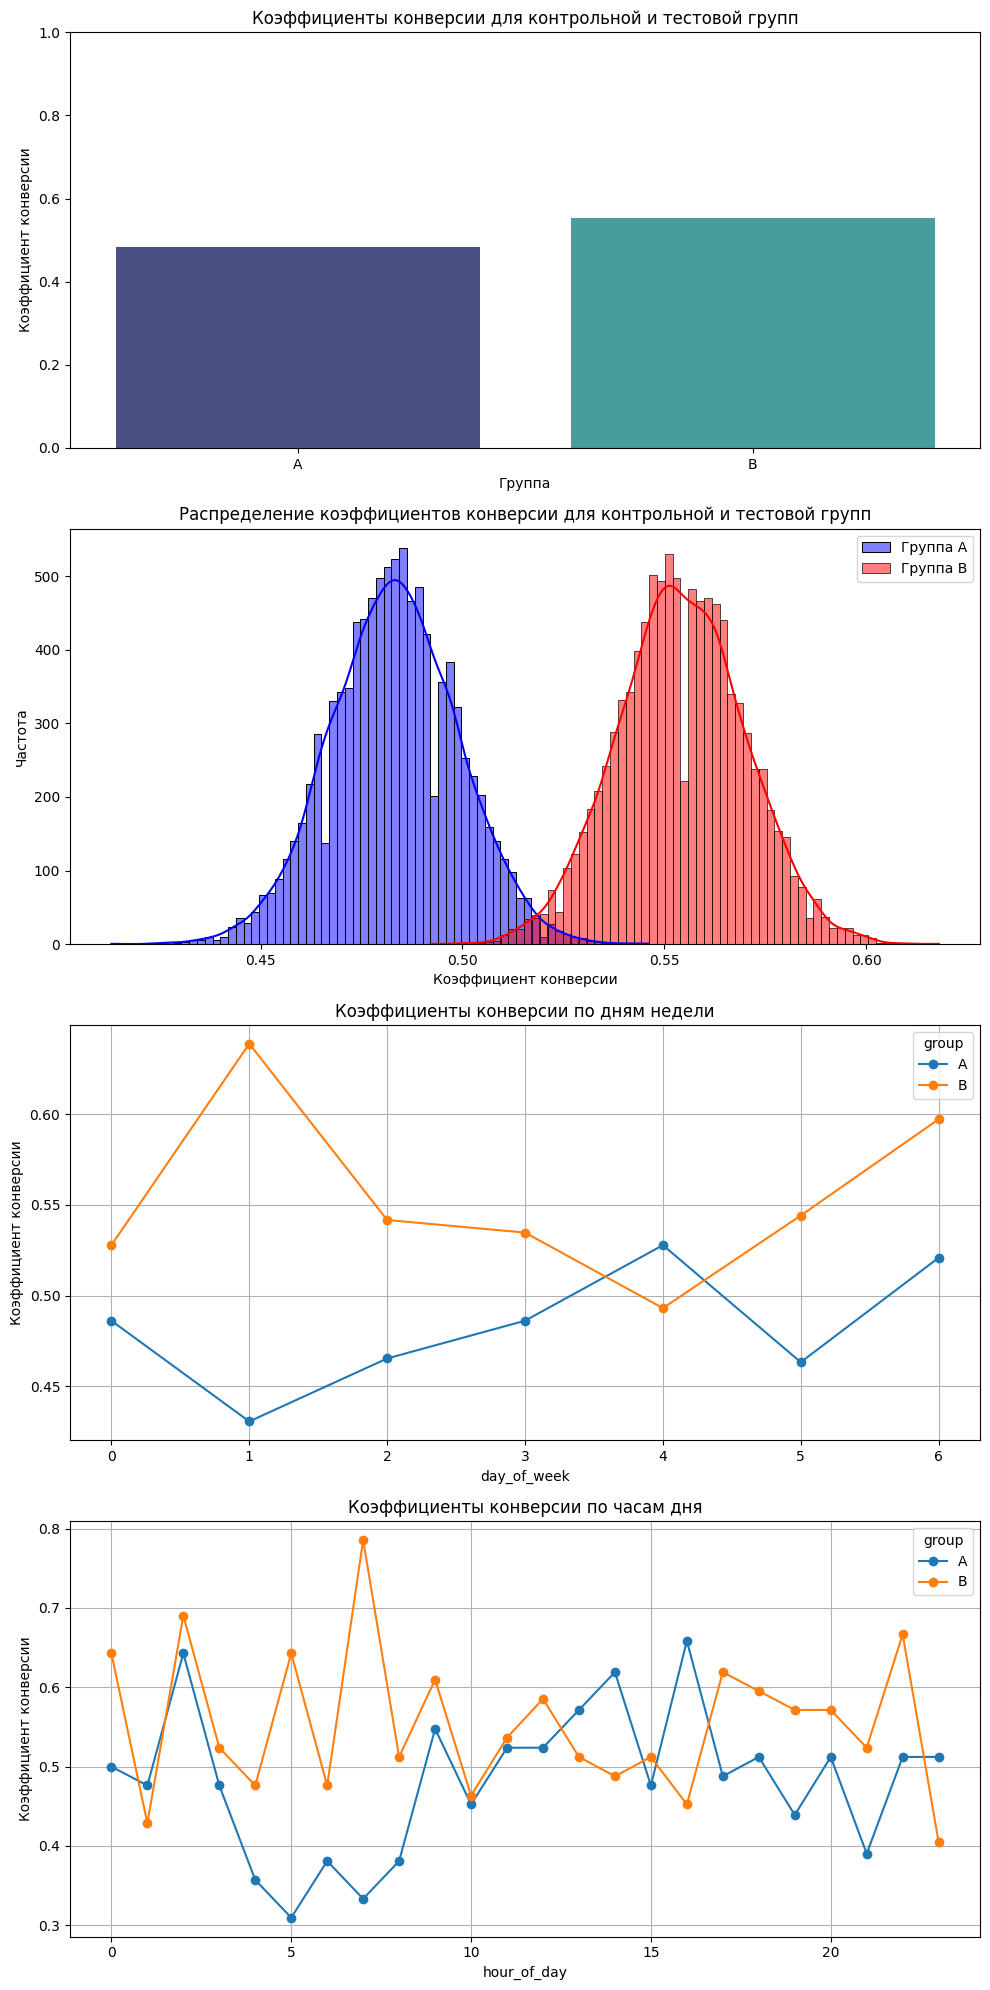

In [6]:
# Строим графики
fig, ax = plt.subplots(4, 1, figsize=(10, 20))

# Коэффициенты конверсии для контрольной и тестовой групп
conversion_rates = ab_test_data.groupby('group')['conversion'].mean()
sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette="mako", ax=ax[0])
ax[0].set_title('Коэффициенты конверсии для контрольной и тестовой групп')
ax[0].set_ylabel('Коэффициент конверсии')
ax[0].set_xlabel('Группа')
ax[0].set_ylim(0,1)

# Распределение коэффициентов конверсии для контрольной и тестовой групп
sns.histplot(bootstrap_means_A, color='b', kde=True, label='Группа A', ax=ax[1])
sns.histplot(bootstrap_means_B, color='r', kde=True, label='Группа B', ax=ax[1])
ax[1].set_title('Распределение коэффициентов конверсии для контрольной и тестовой групп')
ax[1].set_ylabel('Частота')
ax[1].set_xlabel('Коэффициент конверсии')
ax[1].legend()

# Коэффициенты конверсии по дням недели
conversion_by_dayofweek.plot(kind='line', marker='o', ax=ax[2])
ax[2].set_title('Коэффициенты конверсии по дням недели')
ax[2].set_ylabel('Коэффициент конверсии')
ax[2].grid(True)

# Коэффициенты конверсии по часам дня
conversion_by_hourofday.plot(kind='line', marker='o', ax=ax[3])
ax[3].set_title('Коэффициенты конверсии по часам дня')
ax[3].set_ylabel('Коэффициент конверсии')
ax[3].grid(True)

plt.tight_layout()
plt.show()


## Часть 6: Вывод результатов теста Хи-квадрат

In [7]:
# Выводим результаты теста Хи-квадрат
print("\nРезультаты теста Хи-квадрат:")
print(f"Статистика Хи-квадрат = {chi2}")
print(f"p-значение = {p_value}")



Результаты теста Хи-квадрат:
Статистика Хи-квадрат = 9.813434591956389
p-значение = 0.0017324166990986848
